In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(42)

In [2]:
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Entering Stocks
### We will let the user enter the following
#### 1. Stocks
#### 2. Weights (optional)
#### 3. Start date of historical data
#### 4. End date of historical data 
#### 5. Number of simulations
#### 6. Number of years

In [3]:
init_invstmnt = int(input('Enter your initial investment:'))
print(f'your initial investment is: ${init_invstmnt}')

Enter your initial investment: 10000


your initial investment is: $10000


In [4]:
#User stocks input
#CODE:
text = input('Enter Stocks separated by comma, up to five stocks only')
test = text.split(',')

Enter Stocks separated by comma, up to five stocks only spy,aapl


In [5]:
#User weights input
#CODE:

#weights = input('Enter weights: ')
#weights = list(map(float,weights.split(',')))
#print(weights)

In [5]:
#User start date of historical prices input
#CODE
start_date = input('Enter Start Date: e.g. 2018-01-01: ')
print(f'your start date is: {start_date}')

Enter Start Date: e.g. 2018-01-01:  2018-01-01


your start date is: 2018-01-01


In [6]:
#User end date of historical prices input
#CODE
end_date = input('Enter End Date: e.g. 2019-01-01')
print(f'your end date is: {end_date}')

Enter End Date: e.g. 2019-01-01 2019-01-01


your end date is: 2019-01-01


In [7]:
#User number of simulaitons input
#CODE
number_simulations = int(input('Enter number of simulations: '))
print(f'number of simulations is {number_simulations}')

Enter number of simulations:  200


number of simulations is 200


In [160]:
#User number of years input 
#CODE
number_years = int(input('Enter number of years:'))

Enter number of years: 30


In [220]:
#Importing Data and cleaning
#CODE

list_of_tickers = text.split(',')
# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
#end_date = datetime.now()
#start_date = end_date + timedelta(-365*100)

start_date = pd.Timestamp(start_date, tz='America/New_York').isoformat()
end_date = pd.Timestamp(end_date, tz='America/New_York').isoformat()
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df = df.sort_index()
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df = df.droplevel(axis=1, level=1)
df.index = df.index.date
df.dropna(inplace=True)
df.tail()

,AAPL,AMZN,GOOG,MSFT
2018-12-24,146.62,1342.91,975.00,94.0400
2018-12-26,157.18,1470.81,1039.19,100.5300
2018-12-27,156.12,1462.00,1043.89,101.0500
2018-12-28,156.07,1475.18,1036.20,100.3487
2018-12-31,156.70,1492.38,1029.11,100.8300


In [221]:
df.count()

AAPL    251
AMZN    251
GOOG    251
MSFT    251
dtype: int64

In [222]:
# Calculate the daily returns for the given stocks closing prices
#CODE
means = {}
daily_returns = df.pct_change()
daily_returns.dropna(inplace=True)

for stock in list_of_tickers:
    print(stock)
    means[stock] = daily_returns.mean()[stock]
    print(f'{stock} mean: {means[stock]}')

AAPL
AAPL mean: -0.00021250953939727112
AMZN
AMZN mean: 0.0011707734649056127
MSFT
MSFT mean: 0.0007977924615533376
GOOG
GOOG mean: 2.176086064539051e-05


In [223]:
# Volatility for the given stocks closing prices
#CODE
std = {}
for stock in list_of_tickers:
    print(stock)
    std[stock] = daily_returns.std()[stock]
    print(f'{stock} std: {std[stock]}')

AAPL
AAPL std: 0.018249444944860638
AMZN
AMZN std: 0.022885160247310295
MSFT
MSFT std: 0.01777214106274319
GOOG
GOOG std: 0.017801507907868688


In [224]:
# Last day's closing price for the stocks and save those as variables
#CODE
last_day = {}
for stock in list_of_tickers:
    print(stock)
    last_day[stock] = df[stock][-1]
    print(f'{stock} last days closing price: {last_day[stock]}')

AAPL
AAPL last days closing price: 156.7
AMZN
AMZN last days closing price: 1492.38
MSFT
MSFT last days closing price: 100.83
GOOG
GOOG last days closing price: 1029.11


## Run Monte Carlo Simulation:
#### - We run (n) simulations, using Monte Carlo Algorithms to simulate future prices
#### - After computing the simulated prices, we get to the portfolio average return individual stocks, so we weight stocks in the portfolio
#### - We create an empty list for the Monte Carlo optimal weights
#### - Each simulation has its own optimal weights, therefore, we create a variable to hold the weights so we can save them to calculate the average 
#### - instead of computing weights manually, we can find the optimal weights that maximize Sharpe ratio mathematically using optimization technics (using SciPy)
#### - Given the simulated prices, we use SciPy's built-in optimization algorithms to calculate the optimal weights


In [225]:
#how to find the optimal weights for your portfolio?

# Setup the Monte Carlo Parameters
#1. In the Monte Carlo simulation, we used the number of years entered by the user, and multiply it by the trading days

#number_simulations = 500
number_records = (number_years * 252) 
monte_carlo = pd.DataFrame()
number_records


# We need to keep the optimal weights in order to calculate the average 
mc_opt_weights= []
# we create variable 'simulated_dr_all' to save the daily returns of the simulated prices to use it with the average weights later
simulated_dr_all = []


simulated_prices_all = {stock:pd.DataFrame() for stock in list_of_tickers}
#Monte Carlo simulation


for x in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price 
    simulated_prices = {stock:[last_day[stock]] for stock in list_of_tickers}

    
    for i in range(number_records):
        for stock in list_of_tickers:
            simulated_price = simulated_prices[stock][-1] * (1 + np.random.normal(means[stock], std[stock]))

            simulated_prices[stock].append(simulated_price)
  
    for stock in list_of_tickers:
        simulated_prices_all[stock][x] = pd.Series(simulated_prices[stock])
    simulated_prices_df = pd.DataFrame(simulated_prices)
    #simulated_prices_df = pd.Series(simulated_prices)
 
    simulated_prices_all[x] = simulated_prices_df
    simulated_dr = simulated_prices_df.pct_change()
    simulated_dr.dropna(inplace=True)
    
    simulated_dr_all.append(simulated_dr)
    
# To calculate optimization using Scipy:
#CODE

#STEP ONE (negative Sharpe ratio):

# Define neg_sharpe, which takes in weights and then returns the Sharpe Ratio

    def get_ret_vol_sr(weights):
        weights = np.array(weights)
        
# We calculate return'ret', volatility 'vol', and the Sharpe Ratio 'sr'
        ret = np.sum(simulated_dr.mean() * weights) * 252
        vol = np.sqrt(np.dot(weights.T,np.dot(simulated_dr.cov()*252,weights)))
        sr = ret/vol
        return np.array([ret,vol,sr])
    
    def neg_sharpe(weights):
        # we return neg sharpe ratio because we minimize (there is no maximize function in scipy)
        # To minimize the negative Sharpe Ratio so we're going to multiply it by -1
        return get_ret_vol_sr(weights)[2] * -1
    
#STEP TWO (constraints):

# check allocation sums to 1
# Then, define a function with constraints
#One of the constraints is called check_sum() 
#since our allocations needs to add up to one, this function is going to return 0 if the sum of the weights is 1, 
#if not, it returns how far you are from 1.
    def check_sum(weights): 
        return np.sum(weights) - 1 
    
    # create constraint variable
# Since we only have one constraint (which is sum of 1) we create a variable called 'cons', which is a tuple with a dictionary inside of it.
# The dictionary takes in a first argument 'type':'eq' - which is an equation type of constraint. 
# The second argument is a function and we pass in the function itself 'fun':check_sum.
    cons = ({'type':'eq','fun':check_sum}) 

#STEP THREE (boundaries):
    # create weight boundaries
    bounds = [(0,1)]*len(list_of_tickers)
    
#STEP FOUR (weights initial guess):
# We create an even distribution initial guess of weights to start with
    init_guess = [1/len(list_of_tickers)] * len(list_of_tickers)

#STEP FIVE (importing SciPy and call minimize):

# Import the minimize optimization algorithm from scipy.optimize
    from scipy.optimize import minimize

# We put all of these functions into the minimization function
# Then, We call minimize and pass in what we're trying to minimize:
# negative Sharpe
# our initial guess 
# we set the minimization method to SLSQP 
# and we set our bounds and constraints:
    opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    
#The optimal results are stored in the x array so we call opt_results.x
# with get_ret_vol_sr(opt_results.x) we can see the optimal results 
    opt_weights = opt_results.x
    
    mc_opt_weights.append(opt_weights)
    print(opt_weights)
    #portfolio_daily_returns = simulated_dr.dot(weights)
    portfolio_daily_returns = simulated_dr.dot(opt_weights)
    

    
    
    
    monte_carlo[x] = (1+portfolio_daily_returns.fillna(0)).cumprod()
    




[0.         0.42439424 0.45642491 0.11918085]
[0.         0.39346349 0.51762858 0.08890792]
[0.00000000e+00 3.40920297e-01 6.59079703e-01 1.32339562e-18]
[1.62630331e-18 4.94439911e-01 4.17756397e-01 8.78036924e-02]
[0.         0.55095911 0.44904089 0.        ]
[7.72720428e-17 3.83350810e-01 6.16649190e-01 0.00000000e+00]
[0.         0.30826063 0.48574104 0.20599833]
[0.00000000e+00 4.44743042e-01 5.55256958e-01 1.19247317e-17]
[5.17321217e-02 3.84970911e-01 5.63296967e-01 8.63567030e-17]
[0.00000000e+00 3.74094359e-01 6.25905641e-01 2.11576458e-17]
[9.21571847e-18 4.69458679e-01 3.42431288e-01 1.88110033e-01]
[1.39557674e-17 4.33531273e-01 5.66468727e-01 0.00000000e+00]
[0.         0.36658781 0.52473514 0.10867705]
[0.         0.60620312 0.38625302 0.00754386]
[0.         0.45522768 0.54477232 0.        ]
[5.18737739e-17 5.29098832e-01 4.70901168e-01 0.00000000e+00]
[0.08929356 0.38188934 0.48941719 0.03939991]
[0.00000000e+00 5.66184965e-01 4.33815035e-01 3.16455237e-18]
[0.00000000e

In [189]:
monte_carlo

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
1,1.009904,0.981158,0.983835,1.020710,1.007078,1.014971,1.011780,1.010708,1.014223,0.981920,...,1.005809,1.001199,0.999250,1.009210,1.006155,1.010095,0.985861,1.004494,0.970331,1.026781
2,1.024710,0.975048,1.014126,1.038569,1.008663,0.999795,1.020245,1.031742,1.016706,0.998633,...,0.992652,1.015519,1.003364,0.999776,0.992582,1.019166,0.986808,0.997044,0.963827,1.024516
3,1.001373,0.972821,0.994732,1.050865,0.988136,0.998635,1.027163,1.054271,1.032879,0.984379,...,0.993976,1.029098,0.999033,0.986490,0.968632,1.020336,0.967382,1.006136,0.936371,1.018619
4,0.999863,0.984522,0.998348,1.039970,1.006287,1.001083,1.038282,1.057072,1.018125,0.976617,...,0.977839,1.048553,1.011314,0.982873,0.975530,1.027089,0.972440,1.023816,0.946550,1.039919
5,0.997410,0.970236,1.006610,1.038379,1.000123,0.993528,1.026912,1.064756,1.009035,0.970611,...,0.983408,1.076214,1.021776,0.982271,0.947290,1.044370,0.976514,1.050887,0.949411,1.039061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,451.812104,484.154553,337.470901,281.383263,1336.772332,131.653066,922.248701,2085.936175,758.781037,1250.056001,...,252.523708,1002.757912,602.975829,2974.813795,235.861530,219.408540,406.332031,18256.622606,375.372543,1031.845421
7557,465.827404,486.450099,332.397175,281.649456,1352.570539,130.971850,936.524312,2138.180283,761.757616,1235.942594,...,247.715484,1037.111733,594.840843,2980.026635,241.809065,225.317221,408.456134,18130.098829,374.753050,1055.592386
7558,463.793586,486.383761,337.741027,280.240019,1359.167767,127.188484,923.327255,2165.426739,766.212096,1221.853957,...,248.948057,1044.723828,595.445977,3010.160173,248.129306,221.517866,406.546954,17579.720286,373.563829,1056.998177
7559,469.435466,470.335290,337.091926,276.795395,1371.870289,127.404029,969.582069,2168.034448,776.589843,1237.885251,...,247.496849,1023.133255,598.274079,2975.414070,248.041029,222.538922,409.454184,17741.763124,372.573660,1032.747332


In [190]:
mc_opt_weights

[array([4.77252244e-17, 3.86087069e-01, 5.01691415e-01, 1.12221516e-01]),
 array([2.30753671e-17, 5.35575871e-01, 4.64424129e-01, 3.23718761e-17]),
 array([5.06239664e-16, 4.04410128e-01, 5.95589872e-01, 2.09396111e-16]),
 array([0.        , 0.34658583, 0.60932476, 0.04408941]),
 array([6.81838004e-16, 3.77524682e-01, 6.22475318e-01, 1.37078896e-16]),
 array([1.85448135e-17, 3.10044818e-01, 6.89955182e-01, 7.19485813e-17]),
 array([3.31635582e-17, 4.01193477e-01, 5.98806523e-01, 1.79086451e-16]),
 array([3.10081819e-17, 4.02615643e-01, 5.21075309e-01, 7.63090483e-02]),
 array([8.25816545e-17, 6.61381528e-01, 3.38618472e-01, 0.00000000e+00]),
 array([0.00000000e+00, 4.26265678e-01, 5.73734322e-01, 3.77151719e-17]),
 array([0.        , 0.46334479, 0.53665521, 0.        ]),
 array([0.        , 0.46971607, 0.53028393, 0.        ]),
 array([0.        , 0.49842503, 0.44151376, 0.06006122]),
 array([3.17129135e-17, 4.20376683e-01, 4.61942911e-01, 1.17680406e-01]),
 array([0.04881492, 0.379095

In [191]:
#We used the simulated prices in the previous monte carlo and test our averaged portfolio
number_records = (number_years * 252) 
monte_carlo_avg_opt = pd.DataFrame()
avg_weights = np.mean(mc_opt_weights,axis=0)
for x in range(number_simulations):

    simulated_dr = simulated_dr_all[x]
    
    portfolio_daily_returns = simulated_dr.dot(avg_weights)
    
    
    monte_carlo_avg_opt[x] = (1+portfolio_daily_returns.fillna(0)).cumprod()

In [192]:
monte_carlo_avg_opt

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
1,1.008640,0.982420,0.985525,1.018163,1.004941,1.016618,1.011557,1.010905,1.013293,0.983616,...,1.007076,1.003136,0.990041,1.006933,1.006185,1.008292,0.985188,1.005187,0.976393,1.024591
2,1.022850,0.976767,1.014353,1.036798,1.009731,1.003290,1.018850,1.032176,1.014550,0.999898,...,0.996592,1.019687,0.996545,0.997347,0.994563,1.010841,0.983762,1.000459,0.968569,1.023815
3,1.001282,0.973913,0.995120,1.050737,0.989933,0.995359,1.027975,1.055920,1.021562,0.983427,...,0.994128,1.032193,0.988027,0.985153,0.970313,1.008553,0.960482,1.008656,0.946377,1.018097
4,1.000288,0.985258,1.000859,1.046636,1.005672,0.995476,1.038292,1.060265,1.009036,0.977056,...,0.985011,1.049325,0.996923,0.983744,0.976071,1.009041,0.962252,1.025331,0.955079,1.041017
5,0.999599,0.972055,1.008257,1.044926,1.001097,0.987757,1.027404,1.070108,0.994586,0.971248,...,0.993902,1.075271,1.004499,0.979368,0.951446,1.027003,0.964673,1.050389,0.955196,1.038358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,580.977933,252.903264,220.917817,234.352260,774.261230,72.457317,621.795200,2394.177418,172.459296,793.745097,...,101.455417,490.015313,537.861881,2228.602470,175.321653,155.442679,239.753206,9877.745099,136.709986,766.186633
7557,598.531130,254.310465,217.811719,235.156713,784.755078,71.892642,630.340951,2452.712531,172.107024,785.166604,...,99.919363,503.093828,539.547926,2227.941131,179.577770,159.233700,239.382603,9832.564043,136.162472,784.284684
7558,596.319373,253.501101,221.702357,235.243892,791.193255,69.950105,621.729501,2481.380734,173.311564,775.420583,...,100.773893,506.626249,537.138093,2248.468316,184.064963,156.729941,238.103019,9565.167643,136.281306,785.847884
7559,603.933256,245.611300,220.804837,231.937588,797.778293,69.614152,653.473634,2483.460706,175.753741,784.293292,...,99.506592,497.743437,538.633452,2225.794724,183.662691,157.263929,241.520826,9638.598445,134.284062,768.997090


In [193]:
# We find the average weights of the optimized weights 
avg_weights = np.mean(mc_opt_weights,axis=0)
std_weights = np.std(mc_opt_weights,axis=0)
for i in range(len(test)):
    print(test[i], avg_weights[i], std_weights[i])


AAPL 0.008589581404674458 0.026628612842048198
AMZN 0.44037881065389883 0.09006290439046777
MSFT 0.49840642603480867 0.0994716070640228
GOOG 0.05262518190661819 0.06952265141110911


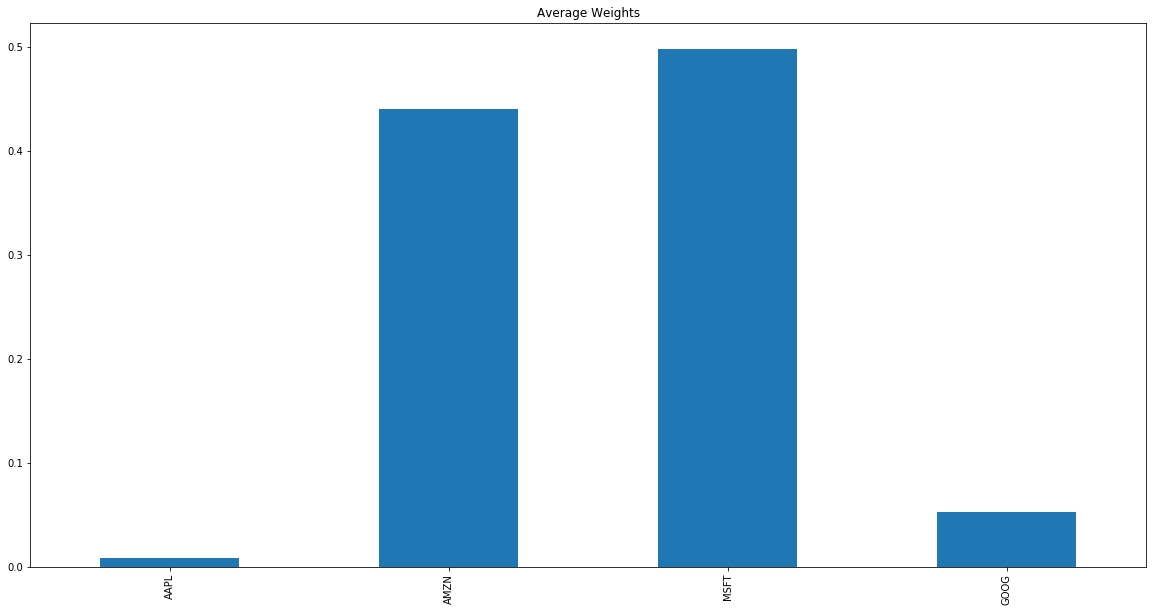

In [194]:
#plot Average weights
pd.Series({list_of_tickers[i]:avg_weights[i] for i in range(len(list_of_tickers))}).plot.bar(figsize=(20, 10), title = 'Average Weights')

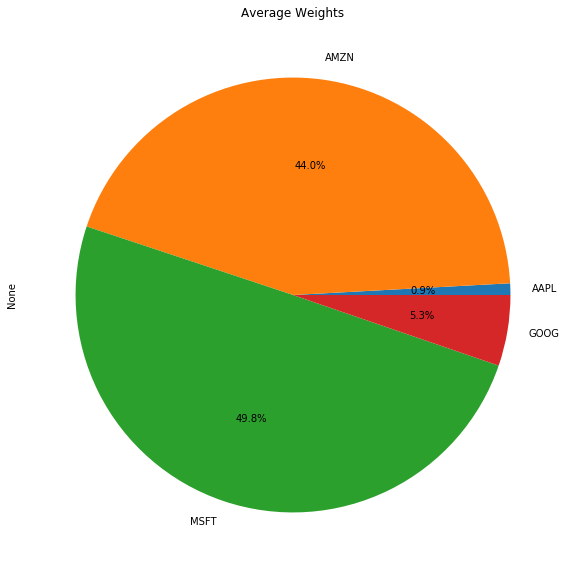

In [195]:
pd.Series({list_of_tickers[i]:avg_weights[i] for i in range(len(list_of_tickers))}).plot.pie(autopct='%1.1f%%', figsize=(20, 10), title = 'Average Weights')

In [196]:
mc_opt_weights

[array([4.77252244e-17, 3.86087069e-01, 5.01691415e-01, 1.12221516e-01]),
 array([2.30753671e-17, 5.35575871e-01, 4.64424129e-01, 3.23718761e-17]),
 array([5.06239664e-16, 4.04410128e-01, 5.95589872e-01, 2.09396111e-16]),
 array([0.        , 0.34658583, 0.60932476, 0.04408941]),
 array([6.81838004e-16, 3.77524682e-01, 6.22475318e-01, 1.37078896e-16]),
 array([1.85448135e-17, 3.10044818e-01, 6.89955182e-01, 7.19485813e-17]),
 array([3.31635582e-17, 4.01193477e-01, 5.98806523e-01, 1.79086451e-16]),
 array([3.10081819e-17, 4.02615643e-01, 5.21075309e-01, 7.63090483e-02]),
 array([8.25816545e-17, 6.61381528e-01, 3.38618472e-01, 0.00000000e+00]),
 array([0.00000000e+00, 4.26265678e-01, 5.73734322e-01, 3.77151719e-17]),
 array([0.        , 0.46334479, 0.53665521, 0.        ]),
 array([0.        , 0.46971607, 0.53028393, 0.        ]),
 array([0.        , 0.49842503, 0.44151376, 0.06006122]),
 array([3.17129135e-17, 4.20376683e-01, 4.61942911e-01, 1.17680406e-01]),
 array([0.04881492, 0.379095

In [197]:
monte_carlo_avg_opt.pct_change().mean()

0      0.000938
1      0.000822
2      0.000807
3      0.000808
4      0.000973
         ...   
195    0.000762
196    0.000821
197    0.001305
198    0.000738
199    0.000964
Length: 200, dtype: float64

In [198]:
monte_carlo.pct_change().mean()

0      0.000895
1      0.000927
2      0.000872
3      0.000832
4      0.001052
         ...   
195    0.000807
196    0.000888
197    0.001396
198    0.000905
199    0.001010
Length: 200, dtype: float64

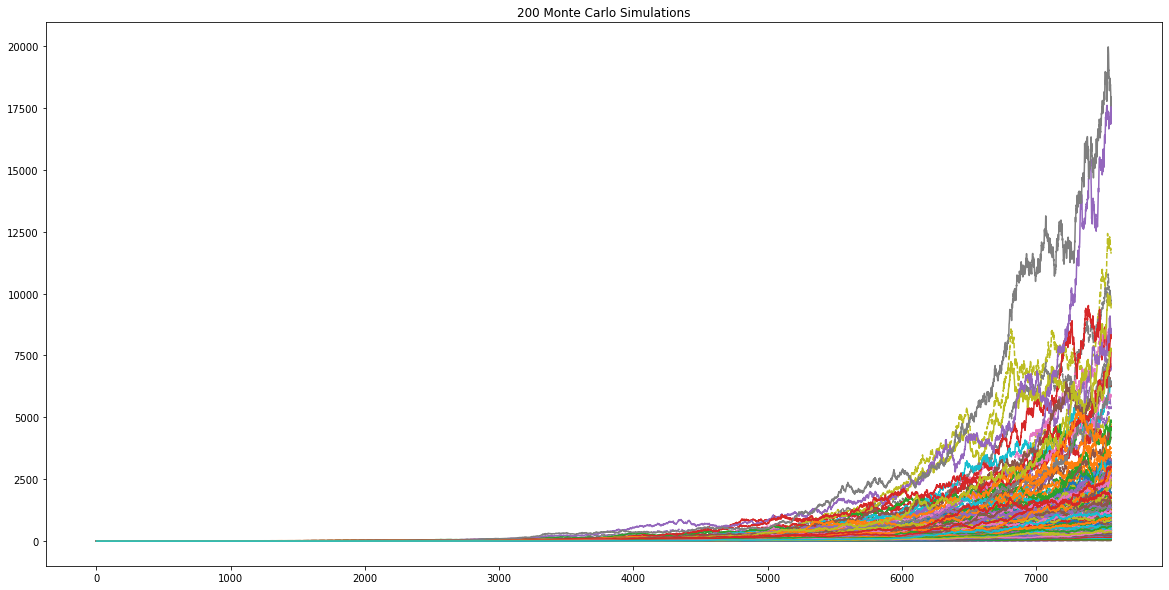

In [199]:
ax = monte_carlo_avg_opt.plot(legend=None, style='--', title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10))
monte_carlo.plot(legend=None, title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10),ax=ax)

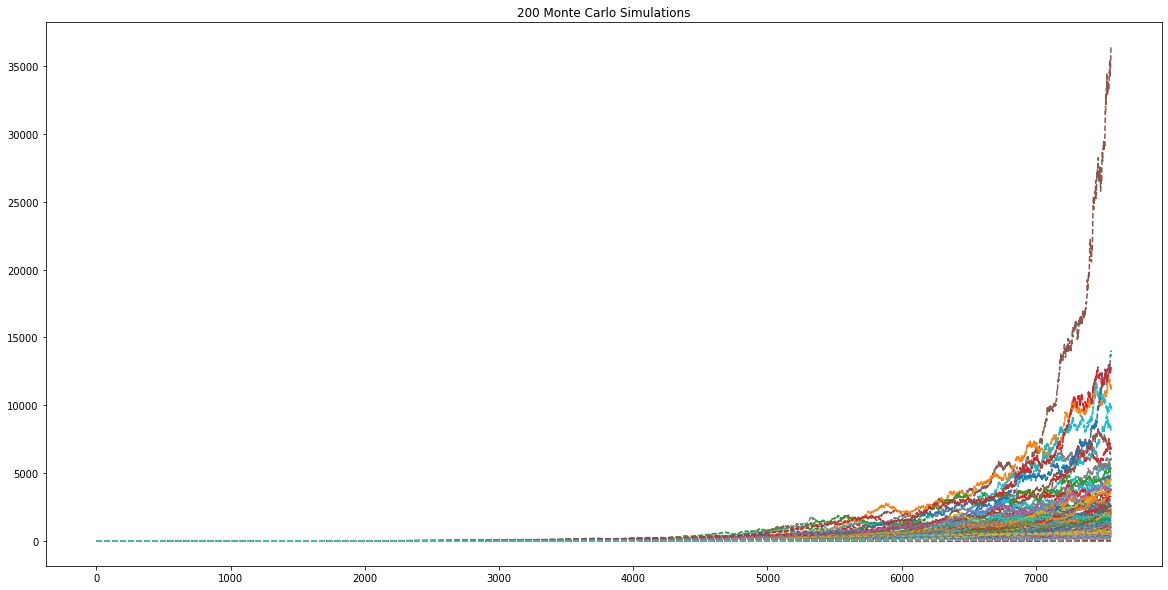

In [180]:
monte_carlo_avg_opt.plot(legend=None, style='--', title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10))

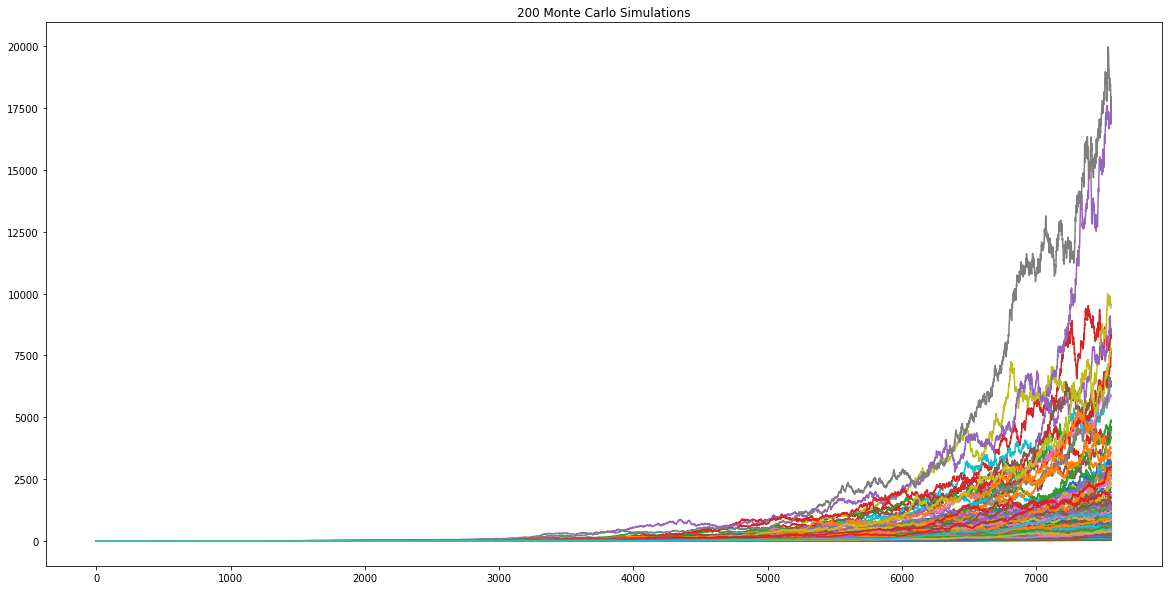

In [200]:
#plot Monte Carlo

monte_carlo.plot(legend=None, title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10))

In [201]:
monte_carlo_avg_opt.iloc[0]

0      1.008640
1      0.982420
2      0.985525
3      1.018163
4      1.004941
         ...   
195    1.008292
196    0.985188
197    1.005187
198    0.976393
199    1.024591
Name: 1, Length: 200, dtype: float64

In [202]:
monte_carlo_avg_opt.dropna(inplace=True)
monte_carlo_avg_opt

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
1,1.008640,0.982420,0.985525,1.018163,1.004941,1.016618,1.011557,1.010905,1.013293,0.983616,...,1.007076,1.003136,0.990041,1.006933,1.006185,1.008292,0.985188,1.005187,0.976393,1.024591
2,1.022850,0.976767,1.014353,1.036798,1.009731,1.003290,1.018850,1.032176,1.014550,0.999898,...,0.996592,1.019687,0.996545,0.997347,0.994563,1.010841,0.983762,1.000459,0.968569,1.023815
3,1.001282,0.973913,0.995120,1.050737,0.989933,0.995359,1.027975,1.055920,1.021562,0.983427,...,0.994128,1.032193,0.988027,0.985153,0.970313,1.008553,0.960482,1.008656,0.946377,1.018097
4,1.000288,0.985258,1.000859,1.046636,1.005672,0.995476,1.038292,1.060265,1.009036,0.977056,...,0.985011,1.049325,0.996923,0.983744,0.976071,1.009041,0.962252,1.025331,0.955079,1.041017
5,0.999599,0.972055,1.008257,1.044926,1.001097,0.987757,1.027404,1.070108,0.994586,0.971248,...,0.993902,1.075271,1.004499,0.979368,0.951446,1.027003,0.964673,1.050389,0.955196,1.038358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,580.977933,252.903264,220.917817,234.352260,774.261230,72.457317,621.795200,2394.177418,172.459296,793.745097,...,101.455417,490.015313,537.861881,2228.602470,175.321653,155.442679,239.753206,9877.745099,136.709986,766.186633
7557,598.531130,254.310465,217.811719,235.156713,784.755078,71.892642,630.340951,2452.712531,172.107024,785.166604,...,99.919363,503.093828,539.547926,2227.941131,179.577770,159.233700,239.382603,9832.564043,136.162472,784.284684
7558,596.319373,253.501101,221.702357,235.243892,791.193255,69.950105,621.729501,2481.380734,173.311564,775.420583,...,100.773893,506.626249,537.138093,2248.468316,184.064963,156.729941,238.103019,9565.167643,136.281306,785.847884
7559,603.933256,245.611300,220.804837,231.937588,797.778293,69.614152,653.473634,2483.460706,175.753741,784.293292,...,99.506592,497.743437,538.633452,2225.794724,183.662691,157.263929,241.520826,9638.598445,134.284062,768.997090


In [203]:
cumulative_return_last = monte_carlo_avg_opt.iloc[-1]
avg_expected = cumulative_return_last.mean() * init_invstmnt
print(f'With initial investment of {init_invstmnt}, your investment is expected to be: ${round(avg_expected,2)}')

With initial investment of 20000, your investment is expected to be: $20467646.25


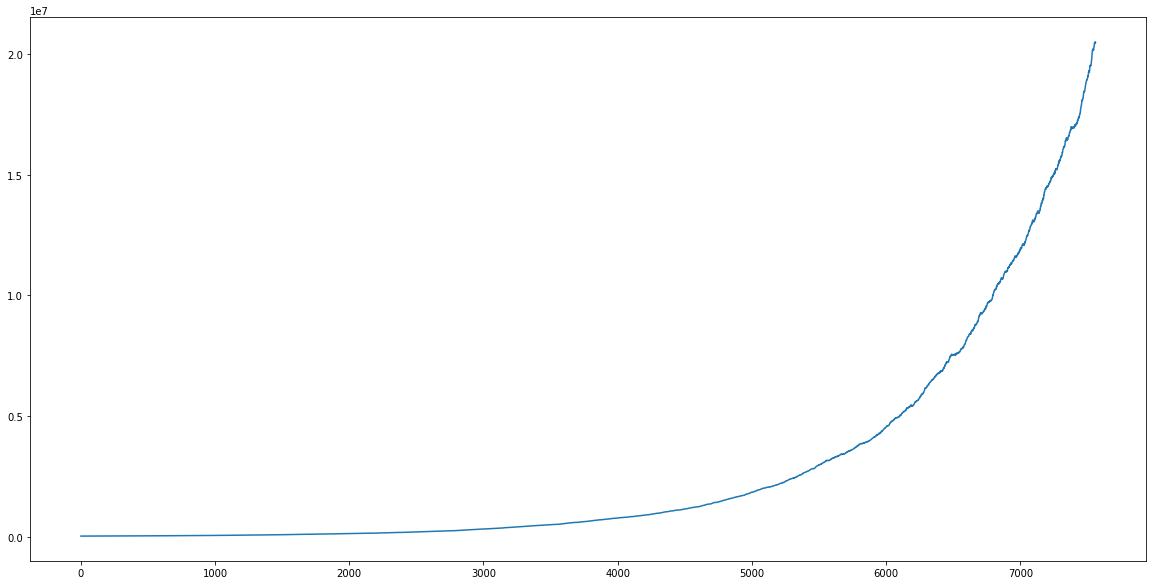

In [204]:
(monte_carlo_avg_opt.mean(axis=1) * init_invstmnt).plot(figsize = (20, 10))

In [206]:
confidence_interval = cumulative_return_last.quantile([0.05,0.95])
confidence_interval

0.05      60.560710
0.95    3282.045355
Name: 7560, dtype: float64

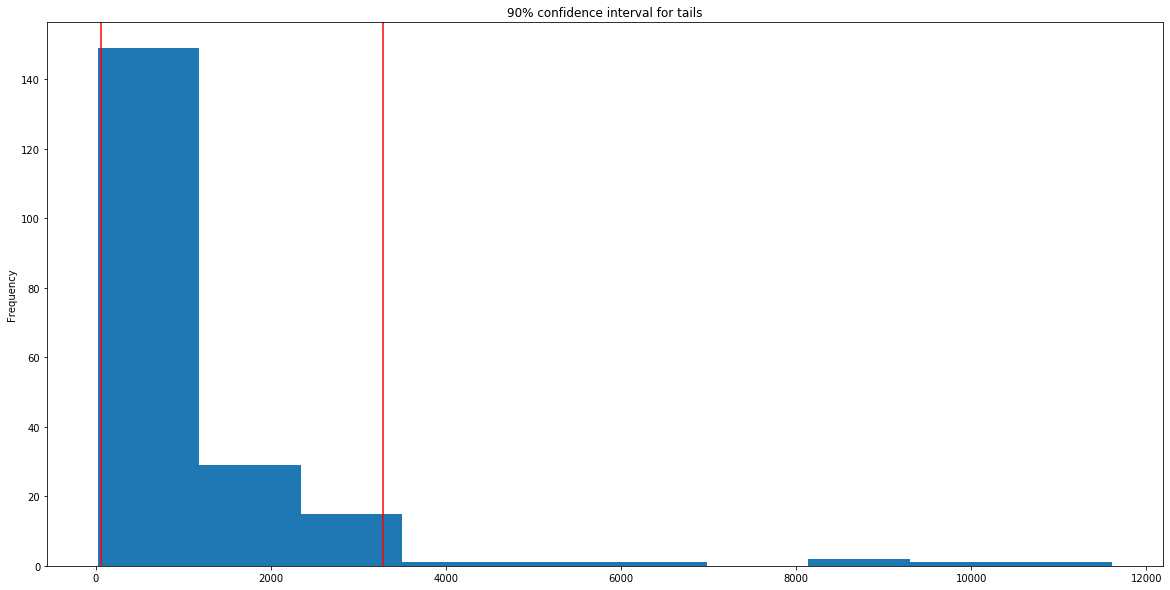

In [207]:
plt.figure()
cumulative_return_last.plot.hist(title="90% confidence interval for tails", figsize = (20,10))
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [208]:
daily_std = simulated_prices_df.std()
daily_std

AAPL        43.635948
AMZN    378319.642685
MSFT      9237.480481
GOOG       211.076093
dtype: float64

In [209]:
daily_std.sort_values(ascending = False)


AMZN    378319.642685
MSFT      9237.480481
GOOG       211.076093
AAPL        43.635948
dtype: float64

In [210]:
#annualized standard deviation
annualized_std = daily_std * np.sqrt(252)
annualized_std

AAPL    6.926992e+02
AMZN    6.005638e+06
MSFT    1.466405e+05
GOOG    3.350729e+03
dtype: float64

In [211]:
simulated_prices_df

,AAPL,AMZN,MSFT,GOOG
0,156.700000,1.492380e+03,100.830000,1029.110000
1,152.348180,1.519354e+03,104.254826,1027.961775
2,152.071853,1.534752e+03,103.006552,1042.845584
3,152.084691,1.530442e+03,102.183024,1035.635172
4,157.397236,1.586477e+03,103.064744,1070.830682
...,...,...,...,...
7556,1.260241,1.421570e+06,29933.271961,364.489299
7557,1.272939,1.499027e+06,29913.648893,363.563185
7558,1.292196,1.490699e+06,30099.655467,371.927320
7559,1.331551,1.459852e+06,29345.632316,371.175883


In [160]:
#pd.DataFrame(simulated_prices_all)

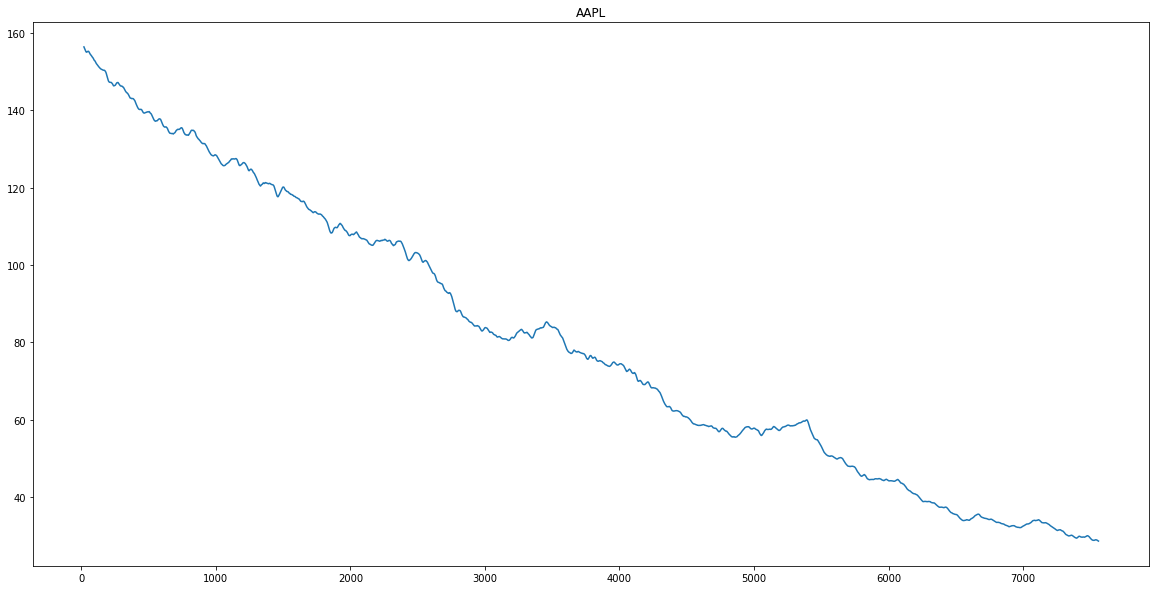

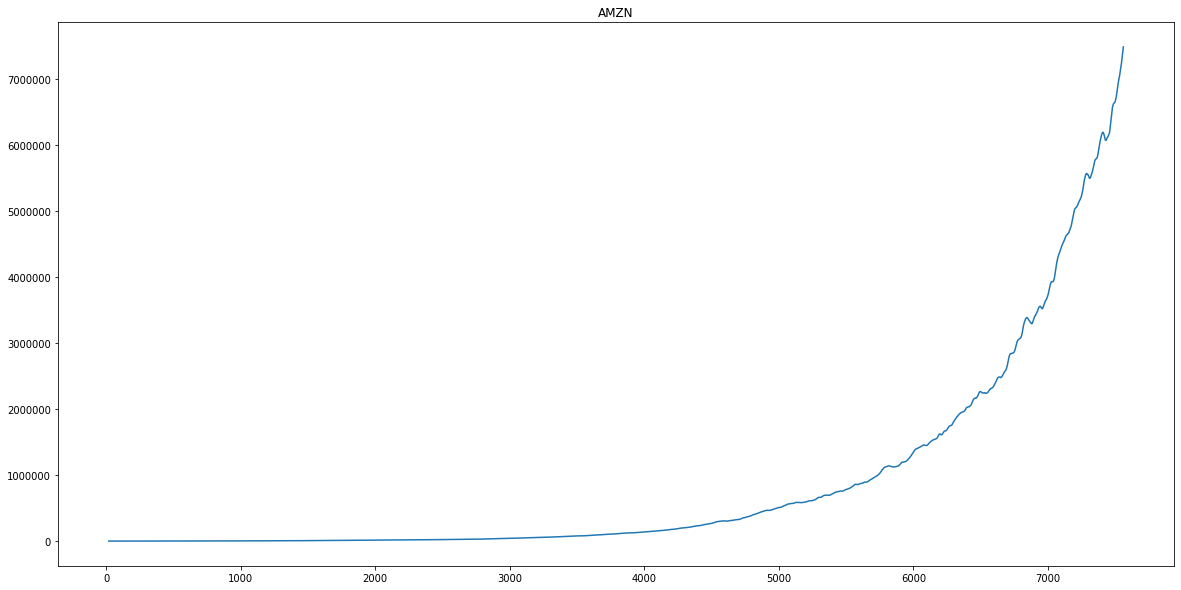

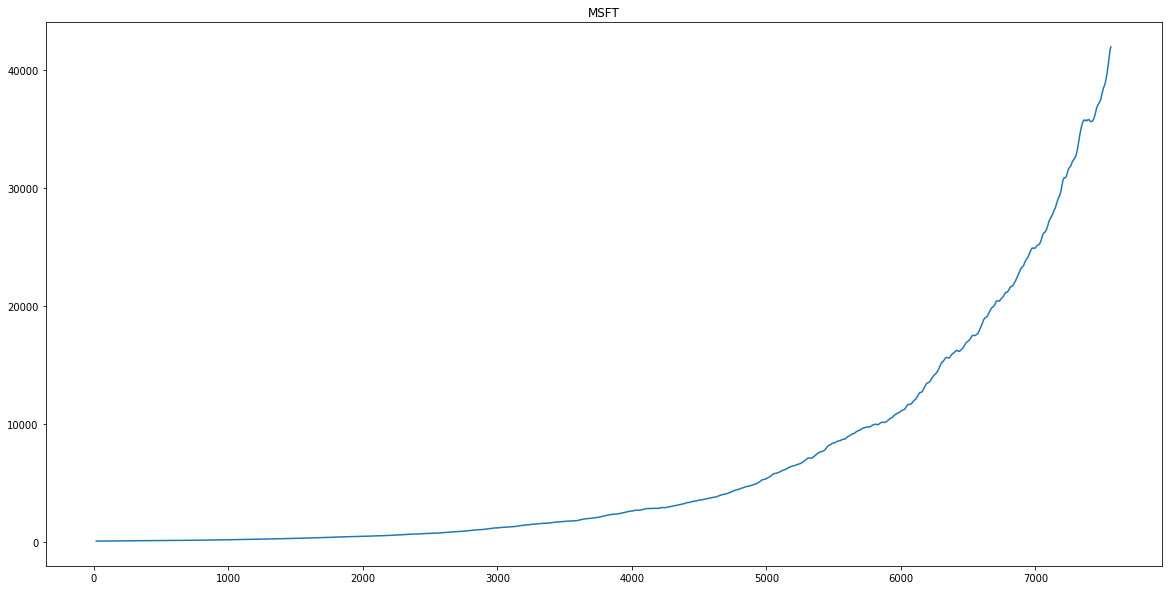

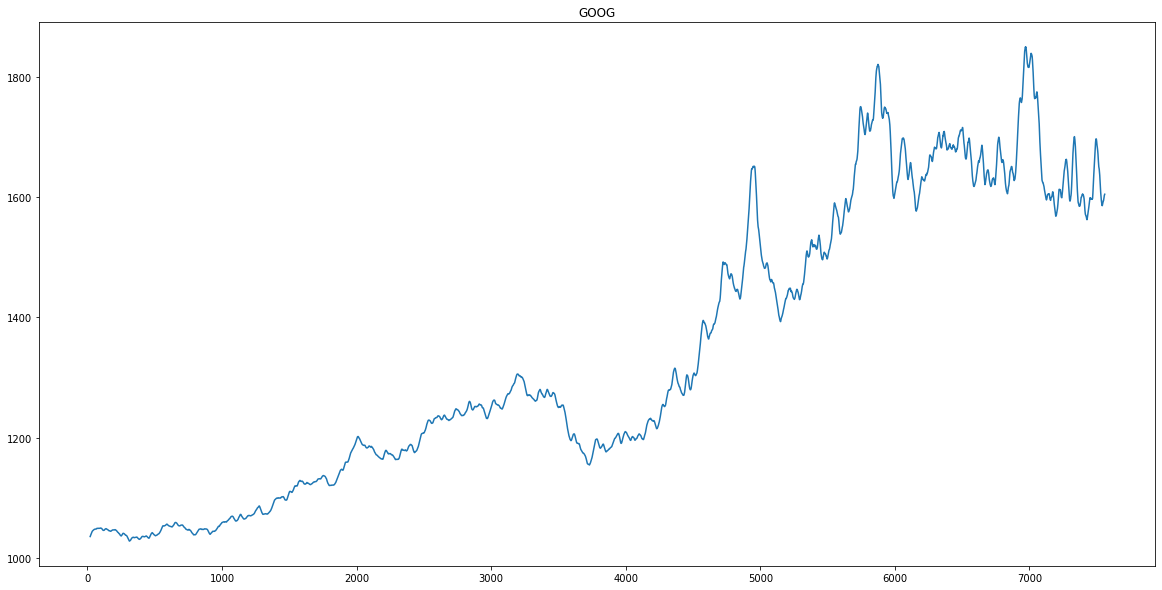

In [212]:
for stock in list_of_tickers:
    plt.figure()
    simulated_prices_all[stock].mean(axis=1).rolling(window=21).mean().plot(title=stock, figsize=(20,10))


In [213]:
correlation = simulated_prices_df.corr()
correlation

,AAPL,AMZN,MSFT,GOOG
AAPL,1.000000,-0.466861,-0.359869,0.796622
AMZN,-0.466861,1.000000,0.869426,-0.024134
MSFT,-0.359869,0.869426,1.000000,0.040443
GOOG,0.796622,-0.024134,0.040443,1.000000


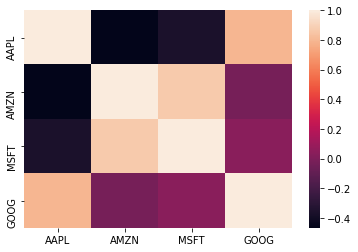

In [214]:
sns.heatmap(correlation)


In [215]:
# Sharpe Ratios
sharpe_ratios = (simulated_prices_df.mean() * 252) / (simulated_prices_df.std() * np.sqrt(252))
sharpe_ratios.sort_values(ascending = False)

GOOG    26.063735
AAPL    13.728336
AMZN     9.556369
MSFT     7.544764
dtype: float64

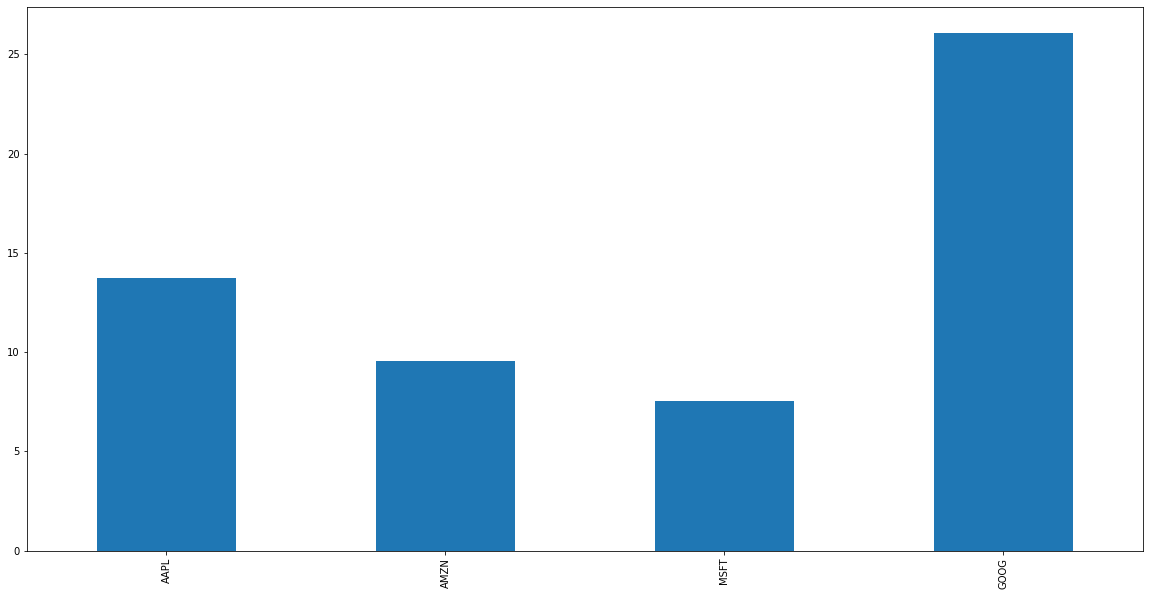

In [216]:
sharpe_ratios.plot.bar(figsize = (20, 10))

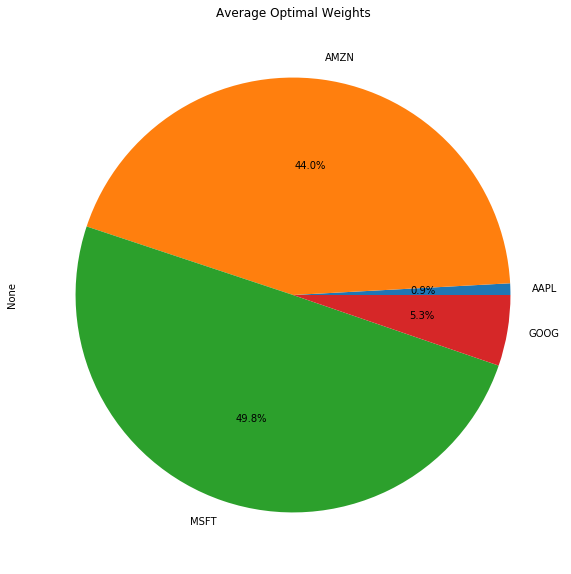

In [217]:
pd.Series({list_of_tickers[i]:avg_weights[i] for i in range(len(list_of_tickers))}).plot.pie(autopct='%1.1f%%', figsize=(20, 10), title = 'Average Optimal Weights')